In [149]:
!pip install underthesea

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import classification_report
from gensim.models import Word2Vec
import underthesea as uts
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
vne_data = pd.read_csv("/content/labeled_sentences_1.csv", encoding='utf8', engine='python').dropna()
vs_data = pd.read_csv("/content/labeled_sentences_2.csv", encoding='utf8', engine='python').dropna()
label1 = pd.read_csv("/content/labeled_sentences_3.csv", encoding='utf8', engine='python').dropna()
label2 = pd.read_csv("/content/vietstock_articles_23_2thang.csv", encoding='utf8', engine='python').dropna()
label3 = pd.read_csv("/content/vneconomy_articles_23_1nam.csv", encoding='utf8', engine='python').dropna()
merge_label = pd.concat([label1, label2, label3]).reset_index(drop=True)

# Labeled data insight

In [153]:
merge_label['Sentences']

0       Động thái này không nằm ngoài dự báo trước đó ...
1        Trong những phiên giao dịch tới, thị trường c...
2       Nhà phân tích Craig Erlam của Oanda lưu ý rằng...
3        Vay nợ của Hancorp hiện đang ở mức 5.844 tỷ đ...
4       Trước đó, HAG công bố báo cái tài chính bán ni...
                              ...                        
996      Lợi nhuận sau thuế tăng vọt 163,4% theo năm -...
997     Đồng thời, cũng trong quý 1/2023, công ty thôn...
998     Để đảm bảo thông tin đầy đủ đén nhà đầu tư, HO...
999                                                   NaN
1000                                                  NaN
Name: Sentences, Length: 1001, dtype: object

In [154]:
txt = ''
for s in merge_label['Sentences']:
    # Check if the value is a float and convert it to a string
    if isinstance(s, float):
        s = str(s)
    txt += s

words = uts.word_tokenize(txt)

In [155]:
clean_words = [re.sub('[^\w\s]', '', word) for word in words]
clean_words = [re.sub('\d', '', word) for word in clean_words]
clean_words = [word for word in clean_words if word.strip()]

In [156]:
fd = nltk.FreqDist(clean_words)
common_words = fd.most_common(20)

Text(0.5, 1.0, 'Tần suất xuất hiện của các từ trong tập dữ liệu đã gán nhãn')

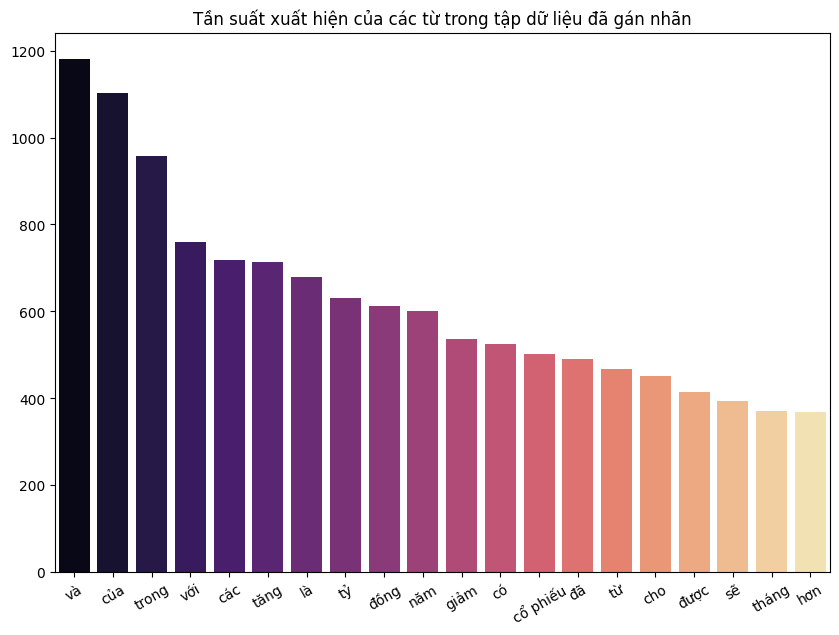

In [157]:
all_fdist = common_words
all_fdist = pd.Series(dict(all_fdist))
fig, ax = plt.subplots(figsize=(10,7))
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, palette='magma', ax=ax)
plt.xticks(rotation=30)
plt.title('Tần suất xuất hiện của các từ trong tập dữ liệu đã gán nhãn')

In [158]:
sentiment_data = merge_label['Sentiment'].value_counts().to_dict()
list(sentiment_data.values())

[395, 318, 286]

Text(0.5, 1.0, 'Tần suất câu mang tính')

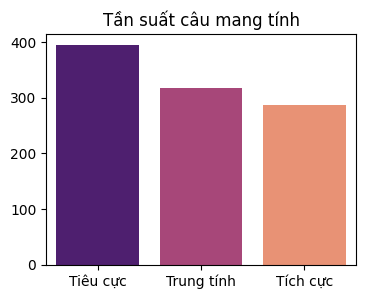

In [159]:
fig, ax = plt.subplots(figsize=(4,3))
lg = ["Tiêu cực","Trung tính","Tích cực"]
all_plot = sns.barplot(x=lg, y=list(sentiment_data.values()), palette='magma', ax=ax)
plt.title('Tần suất câu mang tính')

# Model

In [160]:
merge_label = merge_label.dropna(subset=['Sentences'])

In [161]:
train, test = train_test_split(merge_label, test_size=0.3, shuffle=True)

## SVM with TF-IDF

In [162]:
vectorizer = TfidfVectorizer(tokenizer = uts.word_tokenize,
                             min_df = 0.01,
                             max_df = 0.7,
                             sublinear_tf = True,
                             use_idf = True)

In [163]:
train_vectors = vectorizer.fit_transform(train['Sentences']).toarray()
test_vectors = vectorizer.transform(test['Sentences']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [169]:
# Perform classification with SVM
svm_classifier = svm.SVC(kernel='poly', degree=1)
svm_classifier.fit(train_vectors, train['Sentiment'])
svm_prediction = svm_classifier.predict(test_vectors)
report_svm = classification_report(test['Sentiment'], svm_prediction, output_dict=True)
print('positive: ', report_svm['1.0'])
print('negative: ', report_svm['-1.0'])
print('neutral: ', report_svm['0.0'])
#SVM

positive:  {'precision': 0.5903614457831325, 'recall': 0.5384615384615384, 'f1-score': 0.5632183908045977, 'support': 91}
negative:  {'precision': 0.4025974025974026, 'recall': 0.37349397590361444, 'f1-score': 0.38749999999999996, 'support': 83}
neutral:  {'precision': 0.5214285714285715, 'recall': 0.5793650793650794, 'f1-score': 0.5488721804511278, 'support': 126}


In [170]:
#Test
review = "Chứng khoán ngày hôm qua biến động, tăng mạnh mẽ."
review_vector = vectorizer.transform([review]).toarray()
print(svm_classifier.predict(review_vector))

[0.]


## SVM with Word2Vec

In [171]:
train_sentences = train['Sentences'].apply(uts.word_tokenize)
test_sentences = test['Sentences'].apply(uts.word_tokenize)

In [166]:
w2v_model = Word2Vec(train_sentences, min_count=1, window=5)

In [167]:
# Function to convert sentences to their vector representations
def sentence_to_vec(sentence, model):
    return np.mean([model.wv[word] for word in sentence if word in model.wv], axis=0)

In [32]:
train_vectors = train_sentences.apply(lambda x: sentence_to_vec(x, w2v_model))
test_vectors = test_sentences.apply(lambda x: sentence_to_vec(x, w2v_model))

In [33]:
svm_classifier = svm.SVC(kernel='poly', degree=1)
svm_classifier.fit(np.vstack(train_vectors.values), train['Sentiment'])
svm_prediction = svm_classifier.predict(np.vstack(test_vectors.values))
report_svm = classification_report(test['Sentiment'], svm_prediction, output_dict=True)
print('positive: ', report_svm['1.0'])
print('negative: ', report_svm['-1.0'])
print('neutral: ', report_svm['0.0'])

positive:  {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 89}
negative:  {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 81}
neutral:  {'precision': 0.43333333333333335, 'recall': 1.0, 'f1-score': 0.6046511627906976, 'support': 130}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
#Test
review = "Chứng khoán ngày hôm qua biến động, tăng mạnh mẽ. nhất."
review_sentence = uts.word_tokenize(review)
review_vector = sentence_to_vec(review_sentence, w2v_model)
review_vector = np.array(review_vector).reshape(1, -1)
svm_prediction = svm_classifier.predict(review_vector)
print(svm_prediction)


ValueError: ignored

## Vanilla Neural Network

In [197]:
vectorizer = TfidfVectorizer(tokenizer = uts.word_tokenize,
                             min_df = 0.01,
                             max_df = 0.7,
                             sublinear_tf = True,
                             use_idf = True)

In [198]:
train_vectors = vectorizer.fit_transform(train['Sentences']).toarray()
test_vectors = vectorizer.transform(test['Sentences']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [176]:
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [196]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [201]:
history = model.fit(train_vectors, train['Sentiment'], epochs=15, batch_size=10)

Epoch 1/15


ValueError: ignored

In [180]:
model = Sequential()
input_shape = train_vectors.shape[1]  # Số lượng đặc trưng trong train_vectors
model.add(Dense(12, input_shape=(input_shape,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [181]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [182]:
model = Sequential()
model.add(Dense(12, input_shape=(100,), activation='relu'))  # Cập nhật kích thước đầu vào thành (100,)
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))